# Mutlimodal integration QC and analysis Figure 2

## Load packages and utils

In [1]:
# Load packages
import scanpy as sc
import muon as mu
from muon import prot as pt
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from copy import copy
import numpy as np
import biomart
import scrublet 
import anndata as ad
import os, sys

# Import utils
# Get the current working directory
current_dir = os.getcwd()
utils_path = os.path.join(current_dir, '../..', 'utils')
sys.path.append(utils_path)

# Import emd function
from adt_utils import convert_ensg_to_gene_names

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

sc.settings.verbosity = 3 

In [2]:
# Setup the global plotting parameters
sc.logging.print_header()

sc.set_figure_params(dpi=100, color_map = 'viridis', frameon=True, transparent=True,
                    dpi_save=800, facecolor='None', format='pdf', figsize=[5,5])

sns.set_style("whitegrid", {'axes.grid' : False})

# Set seed
np.random.seed(0)

# Colour maps
colour_dict_full = {'PDO_DMSO_PDO': '#8383FF', # 
               'PDO_SN38_PDO': '#531B93',  # 
               'PDO_DMSO_PDO_CAF': '#E39097', # 
               'PDO_SN38_PDO_CAF':'#941751', # 
               'Fibroblast_DMSO_CAF': '#c3e7ff', # 
               'Fibroblast_SN38_CAF': '#004c6d', # 
               'Fibroblast_DMSO_PDO_CAF': '#FECEF1', # 
               'Fibroblast_SN38_PDO_CAF' : '#D322A6'} # 

colour_dict_sample = {'DMSO_PDO': '#8383FF', 
               'SN38_PDO': '#531B93',  
               'DMSO_PDO_CAF': '#E39097', 
               'SN38_PDO_CAF':'#941751', 
               'DMSO_CAF': '#C0C0C0', 
               'SN38_CAF': '#5E5E5E'} 

colour_dict_cell_type = {'PDO': '#76B166', # Greeny
                         'Fibroblast': '#FF7F7F'} # Pink


scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


In [3]:
gene_conversion_map = convert_ensg_to_gene_names()

## Load anndata objects filter and merge with muon

In [4]:
# FP for prepped SIGNAL-seq RNA lib
input_file_rna_76 = '../../../F2_pdo21_code/00_preprocessing_rna/splitRtools_outputs/ex0015_rna_76/filtered/h5ad_objects/ex0015_rna_76_sce_filtered.h5ad' 
input_file_rna_77 = '../../../F2_pdo21_code/00_preprocessing_rna/splitRtools_outputs/ex0015_rna_77/filtered/h5ad_objects/ex0015_rna_77_sce_filtered.h5ad'
input_file_rna_78 = '../../../F2_pdo21_code/00_preprocessing_rna/splitRtools_outputs/ex0015_rna_78/filtered/h5ad_objects/ex0015_rna_78_sce_filtered.h5ad'
input_file_rna_79 = '../../../F2_pdo21_code/00_preprocessing_rna/splitRtools_outputs/ex0015_rna_79/filtered/h5ad_objects/ex0015_rna_79_sce_filtered.h5ad'

# h5ad file exported from preprocessing pipeline
adata_mrna_76 = sc.read_h5ad(input_file_rna_76, backed=False) 
adata_mrna_77 = sc.read_h5ad(input_file_rna_77, backed=False) 
adata_mrna_78 = sc.read_h5ad(input_file_rna_78, backed=False) 
adata_mrna_79 = sc.read_h5ad(input_file_rna_79, backed=False) 

In [5]:
# Examine RNA object
print(adata_mrna_76, ": data shape:", adata_mrna_76.shape)
print(adata_mrna_77, ": data shape:", adata_mrna_77.shape)
print(adata_mrna_78, ": data shape:", adata_mrna_78.shape)
print(adata_mrna_79, ": data shape:", adata_mrna_79.shape)

AnnData object with n_obs × n_vars = 9147 × 46578
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info'
    layers: 'reads' : data shape: (9147, 46578)
AnnData object with n_obs × n_vars = 9989 × 48337
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info'
    layers: 'reads' : data shape: (9989, 48337)
AnnData object with n_obs × n_vars = 9318 × 46266
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info'
    layers: 'reads' : data shape: (9318, 46266)
AnnData object with n_obs × n_vars = 9691 × 46914
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads'
    uns: 'X_nam

In [6]:
# Revert to the original barcode sequences
adata_mrna_76.obs.index = adata_mrna_76.obs['barcode_seq']
adata_mrna_77.obs.index = adata_mrna_77.obs['barcode_seq']
adata_mrna_78.obs.index = adata_mrna_78.obs['barcode_seq']
adata_mrna_79.obs.index = adata_mrna_79.obs['barcode_seq']

In [7]:
# Merge the RNA data
adatas_rna_21 = {
    "76": adata_mrna_76,
    "77": adata_mrna_77,
    "78": adata_mrna_78,
    "79": adata_mrna_79,
}

rna_adata_merge = ad.concat(adatas_rna_21, label='sublib_index', join="outer", index_unique="_")

print(rna_adata_merge, ": data shape:", rna_adata_merge.shape)

AnnData object with n_obs × n_vars = 38145 × 52576
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index'
    layers: 'reads' : data shape: (38145, 52576)


In [8]:
# Extract Gene Ids
gene_ids = rna_adata_merge.var_names

# Generate DataFrame with a column containing gene IDs
data = {'Gene_ID': gene_ids}
gene_names_df = pd.DataFrame(data)

# Replace gene IDs with gene names using the conversion map
gene_names_df['Gene_Name'] = gene_names_df['Gene_ID'].replace(gene_conversion_map)

gene_names_df_test = gene_names_df

In [9]:
# Replace empty strings 
gene_names_df['Gene_Name'].replace("", np.NaN, inplace=True)

# Fill NaN values with corresponding 'Gene_ID'
gene_names_df['Gene_Name'].fillna(gene_names_df['Gene_ID'], inplace=True)

gene_names_df

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_58197/2278544122.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gene_names_df['Gene_Name'].replace("", np.NaN, inplace=True)
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_58197/2278544122.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

,Gene_ID,Gene_Name
0,ENSG00000000003,TSPAN6
1,ENSG00000000005,TNMD
2,ENSG00000000419,DPM1
3,ENSG00000000457,SCYL3
4,ENSG00000000460,FIRRM
...,...,...
52571,ENSG00000291308,ENSG00000291308
52572,ENSG00000291309,LY6S
52573,ENSG00000291310,ENSG00000291310
52574,ENSG00000291316,TMEM276-ZFTRAF1


In [10]:
gene_names_df.index = gene_names_df['Gene_Name']
gene_names_df

,Gene_ID,Gene_Name
Gene_Name,,
TSPAN6,ENSG00000000003,TSPAN6
TNMD,ENSG00000000005,TNMD
DPM1,ENSG00000000419,DPM1
SCYL3,ENSG00000000457,SCYL3
FIRRM,ENSG00000000460,FIRRM
...,...,...
ENSG00000291308,ENSG00000291308,ENSG00000291308
LY6S,ENSG00000291309,LY6S
ENSG00000291310,ENSG00000291310,ENSG00000291310


In [11]:
rna_adata_merge.var = gene_names_df
rna_adata_merge.var_names

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'ENSG00000291295', 'ENSG00000291296', 'ENSG00000291297',
       'ENSG00000291299', 'PRSS30P', 'ENSG00000291308', 'LY6S',
       'ENSG00000291310', 'TMEM276-ZFTRAF1', 'TMEM276'],
      dtype='object', name='Gene_Name', length=52576)

In [12]:
# Label MT genes
rna_adata_merge.var['mt'] = rna_adata_merge.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Generate per cell QC metrics for the annotated genes
sc.pp.calculate_qc_metrics(rna_adata_merge, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(rna_adata_merge, ": data shape:", rna_adata_merge.shape)

AnnData object with n_obs × n_vars = 38145 × 52576
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'reads' : data shape: (38145, 52576)


In [13]:
rna_adata_merge.var_names_make_unique()
rna_adata_merge = rna_adata_merge.copy()

In [14]:
del rna_adata_merge.layers["reads"]

## RNA QC and filtering

In [15]:
# Figure output directory
sc.settings.figdir = '01_mm_rna_pp_figs'

In [16]:
# Define UMI/RDS ratio for potential chimeric barcodes
rna_adata_merge.obs['umi_rds_ratio'] = rna_adata_merge.obs['total_counts'] / rna_adata_merge.obs['mapped_reads']

In [17]:
# Run doublet detection pipeline
# Estimated doublet rate at 3% 
sc.external.pp.scrublet(rna_adata_merge, expected_doublet_rate=0.03, threshold=0.18)

Running Scrublet
filtered out 5568 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)
Embedding transcriptomes using PCA...
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 32.2%
Overall doublet rate:
	Expected   = 3.0%
	Estimated  = 2.2%
    Scrublet finished (0:08:00)


In [18]:
# Define outliers and filter
rna_adata_merge.obs['outlier_total'] = rna_adata_merge.obs.total_counts > 9250 
rna_adata_merge.obs['outlier_ngenes'] = rna_adata_merge.obs.n_genes_by_counts > 4000
rna_adata_merge.obs['lowq_counts'] = rna_adata_merge.obs.total_counts < 500
rna_adata_merge.obs['lowq_mt'] = rna_adata_merge.obs.pct_counts_mt > 15
rna_adata_merge.obs['outlier_rds'] = rna_adata_merge.obs.umi_rds_ratio > 0.4


print('%u cells with large total counts' % (sum(rna_adata_merge.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(rna_adata_merge.obs['outlier_ngenes'])))
print('%u cells with low total counts' % (sum(rna_adata_merge.obs['lowq_counts'])))
print('%u cells with high mitochondrial counts' % (sum(rna_adata_merge.obs['lowq_mt'])))
print('%u cells with high reads ratio' % (sum(rna_adata_merge.obs['outlier_rds'])))


rna_adata_merge = rna_adata_merge[~rna_adata_merge.obs['outlier_total'], :]
rna_adata_merge = rna_adata_merge[~rna_adata_merge.obs['outlier_ngenes'], :]
rna_adata_merge = rna_adata_merge[~rna_adata_merge.obs['lowq_counts'], :]
rna_adata_merge = rna_adata_merge[~rna_adata_merge.obs['lowq_mt'], :]
rna_adata_merge = rna_adata_merge[~rna_adata_merge.obs['outlier_rds'], :]

# Filter out lowly expressed genes and cells with low complexity
sc.pp.filter_genes(rna_adata_merge, min_cells=25)
sc.pp.filter_cells(rna_adata_merge, min_genes=300) 

735 cells with large total counts
524 cells with large number of genes
0 cells with low total counts
1207 cells with high mitochondrial counts
35 cells with high reads ratio
filtered out 18836 genes that are detected in less than 25 cells


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


filtered out 110 cells that have less than 300 genes expressed


In [19]:
# Convert predicted doublet scores to str
rna_adata_merge.obs['predicted_doublet'] = rna_adata_merge.obs['predicted_doublet'].astype(str).astype('category')

# Create doublet mask
# Define outliers and do the filtering for the dataset
rna_adata_merge.obs['doublet_outliers'] = rna_adata_merge.obs.predicted_doublet.isin(['True'])

print('%u cells with high probability of being doublets' % (sum(rna_adata_merge.obs['doublet_outliers'])))

rna_adata_merge = rna_adata_merge[~rna_adata_merge.obs['doublet_outliers'], :]

245 cells with high probability of being doublets


In [20]:
# Examine RNA object shape
print(rna_adata_merge, ": data shape:", rna_adata_merge.shape)

View of AnnData object with n_obs × n_vars = 35791 × 33740
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'scrublet' : data shape: (35791, 33740)


## Map unfiltered ADT data with mRNA data by barcode seq

In [21]:
# Figure output directory
sc.settings.figdir = '02_mm_adt_pp_figs'

In [22]:
# ADT input files
input_file_adt_80_rna_76 = '../../../F2_pdo21_code/01_preprocessing_adt/adt_76/ex0015_adt_80_rna_76_merged.h5ad' 
input_file_adt_81_rna_77 = '../../../F2_pdo21_code/01_preprocessing_adt/adt_77/ex0015_adt_81_rna_77_merged.h5ad'
input_file_adt_82_rna_78 = '../../../F2_pdo21_code/01_preprocessing_adt/adt_78/ex0015_adt_82_rna_78_merged.h5ad'
input_file_adt_83_rna_79 = '../../../F2_pdo21_code/01_preprocessing_adt/adt_79/ex0015_adt_83_rna_79_merged.h5ad'

adata_adt_76 = sc.read(input_file_adt_80_rna_76, backed=False)
adata_adt_77 = sc.read(input_file_adt_81_rna_77, backed=False)
adata_adt_78 = sc.read(input_file_adt_82_rna_78, backed=False)
adata_adt_79 = sc.read(input_file_adt_83_rna_79, backed=False)

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [23]:
# Examine ADT objects
print(adata_adt_76, ": data shape:", adata_adt_76.shape)
print(adata_adt_77, ": data shape:", adata_adt_77.shape)
print(adata_adt_78, ": data shape:", adata_adt_78.shape)
print(adata_adt_79, ": data shape:", adata_adt_79.shape)

AnnData object with n_obs × n_vars = 17565 × 21
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts' : data shape: (17565, 21)
AnnData object with n_obs × n_vars = 17551 × 21
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts' : data shape: (17551, 21)
AnnData object with n_obs × n_vars = 21174 × 21
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcod

In [24]:
# Merge the ADT data
adatas_adt_21 = {
    "76": adata_adt_76,
    "77": adata_adt_77,
    "78": adata_adt_78,
    "79": adata_adt_79,
}

adt_adata_merge = ad.concat(adatas_adt_21, label='sublib_index', join="outer", index_unique="_")

print(adt_adata_merge, ": data shape:", adt_adata_merge.shape)

AnnData object with n_obs × n_vars = 76759 × 21
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'sublib_index' : data shape: (76759, 21)


In [25]:
rna_adata_merge_filt = rna_adata_merge.copy()


# Load data into muon object
mudata_signal = mu.MuData({"rna": rna_adata_merge_filt, "protein": adt_adata_merge})

# Intersect barcodes
mu.pp.intersect_obs(mudata_signal)

# Update object 
mudata_signal.update()
mudata_signal

MuData object with n_obs × n_vars = 35206 × 33761
  2 modalities
    rna:	35206 x 33740
      obs:	'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers'
      var:	'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'scrublet'
    protein:	35206 x 21
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'sublib_index'

In [26]:
prot_adata = mudata_signal.mod['protein']

## Protein ADT adata filtering

In [27]:
# Filter the protein data
# define outliers and filter for the dataset
prot_adata.obs['outlier_nantigens_high'] = prot_adata.obs.n_genes_by_counts > 18
prot_adata.obs['outlier_nantigens_low'] = prot_adata.obs.n_genes_by_counts < 4
prot_adata.obs['outlier_adt_counts_low'] = prot_adata.obs.total_counts < 75
prot_adata.obs['outlier_adt_counts_high'] = prot_adata.obs.total_counts > 5000


print('%u cells with high number of Antigens' % (sum(prot_adata.obs['outlier_nantigens_high'])))
print('%u cells with low number of Antigens' % (sum(prot_adata.obs['outlier_nantigens_low'])))
print('%u cells with low number of ADT counts' % (sum(prot_adata.obs['outlier_adt_counts_low'])))
print('%u cells with high number of ADT counts' % (sum(prot_adata.obs['outlier_adt_counts_high'])))



prot_adata = prot_adata[~prot_adata.obs['outlier_nantigens_high'], :]
prot_adata = prot_adata[~prot_adata.obs['outlier_nantigens_low'], :]
prot_adata = prot_adata[~prot_adata.obs['outlier_adt_counts_low'], :]
prot_adata = prot_adata[~prot_adata.obs['outlier_adt_counts_high'], :]

372 cells with high number of Antigens
3 cells with low number of Antigens
3512 cells with low number of ADT counts
565 cells with high number of ADT counts


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


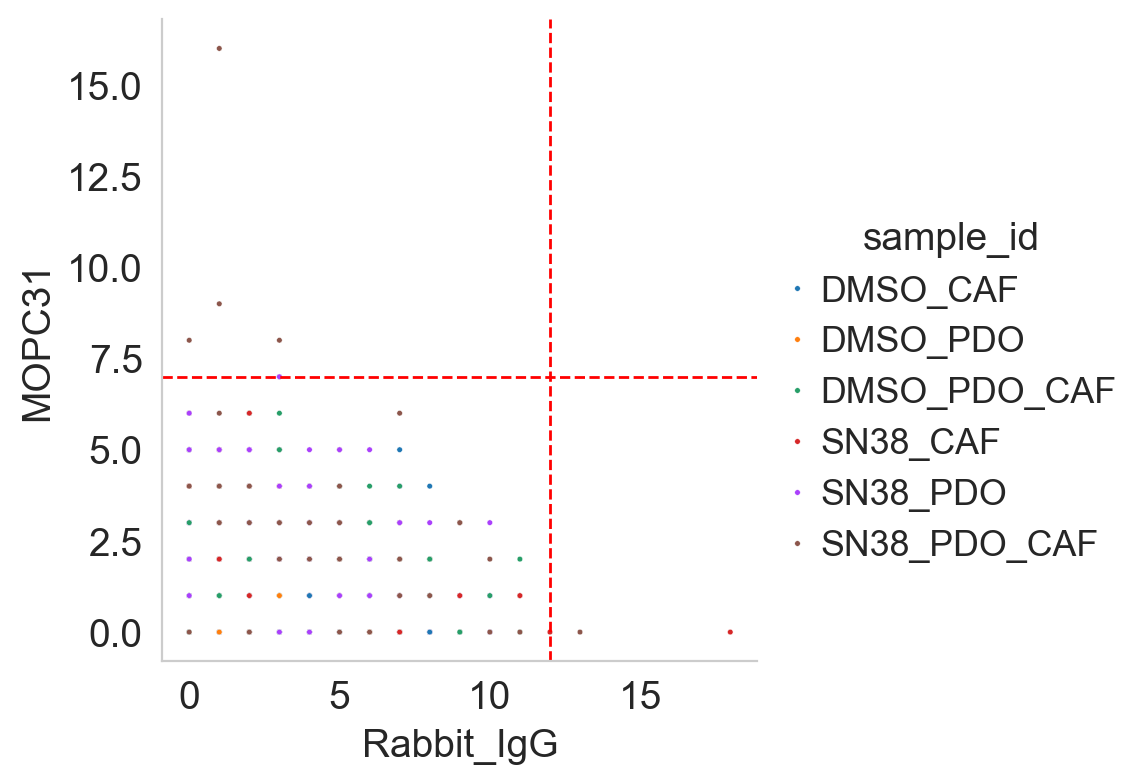

In [29]:
protein_markers = prot_adata.var_names
protein_data = sc.get.obs_df(
    prot_adata,
    keys=['sample_id' , *protein_markers]
)
sns.pairplot(data=protein_data, x_vars="Rabbit_IgG", y_vars="MOPC31", size = 4,
                 plot_kws={"s": 4}, hue='sample_id')

plt.axvline(x=12, ls='--', linewidth=1, color='red')
plt.axhline(y=7, ls='--', linewidth=1, color='red')
                 
plt.savefig('02_mm_adt_pp_figs/mouse_v_rabbit_IgG_control_adt_counts.', dpi=800)

In [30]:
# Filter based on the control antibodies
# Define outliers and do the filtering for the dataset
prot_adata = prot_adata[prot_adata[: , 'MOPC31'].X < 7, :]
prot_adata = prot_adata[prot_adata[: , 'Rabbit_IgG'].X < 12, :]

prot_adata

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_58197/864341321.py:3: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  prot_adata = prot_adata[prot_adata[: , 'MOPC31'].X < 7, :]
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_58197/864341321.py:4: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  prot_adata = prot_adata[prot_adata[: , 'Rabbit_IgG'].X < 12, :]


View of AnnData object with n_obs × n_vars = 30895 × 21
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'sublib_index', 'outlier_nantigens_high', 'outlier_nantigens_low', 'outlier_adt_counts_low', 'outlier_adt_counts_high'

In [31]:
# Copy view for merging
prot_adata_filtered = prot_adata.copy()

# Filter the RNA data with muon
mudata_signal = mu.MuData({"rna": rna_adata_merge_filt, "protein": prot_adata_filtered})

# Intersect barcodes
mu.pp.intersect_obs(mudata_signal)

# Update object 
mudata_signal.update()
mudata_signal

MuData object with n_obs × n_vars = 30895 × 33761
  2 modalities
    rna:	30895 x 33740
      obs:	'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers'
      var:	'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'scrublet'
    protein:	30895 x 21
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'sublib_index', 'outlier_nantigens_high', 'outlier_nantigens_low', 'outlier_adt_counts_low', 'outlier_adt_counts_high'

In [32]:
# Extract RNA and ADT modalities
signal_data_rna = mudata_signal.mod['rna']
signal_data_adt = mudata_signal.mod['protein']

In [33]:
# What is the median protein characteristics after mapping onto mRNA barcodes
print('median RNA UMI count per cell: ' + str(signal_data_rna.obs['total_counts'].median(0)))
print('median gene count per cell: ' + str(signal_data_rna.obs['n_genes_by_counts'].median(0)))
print('pct_mt gene count per cell: ' + str(signal_data_rna.obs['pct_counts_mt'].median(0)))


median RNA UMI count per cell: 2258.0
median gene count per cell: 1279.0
pct_mt gene count per cell: 5.3438891637803065


In [34]:
# What is the median protein characteristics after filtering on low antigen detection
print('median ADT_UMI count per cell: ' + str(prot_adata_filtered.obs['total_counts'].median(0)))
print('median antigen count per cell: ' + str(prot_adata_filtered.obs['n_genes_by_counts'].median(0)))

median ADT_UMI count per cell: 583.0
median antigen count per cell: 12.0


## Normalize RNA modality 

In [35]:
# Figure output directory
sc.settings.figdir = '03_mm_pp_figs'

In [36]:
# Set counts layer for HVG selection
signal_data_rna.layers["counts"] = signal_data_rna.X.copy()

# Count based normalization
sc.pp.normalize_total(signal_data_rna, target_sum=1e4) # Total count normalization to 10000 umi per cell

# Log data
sc.pp.log1p(signal_data_rna)

# save raw log-norm data
signal_data_rna.raw = signal_data_rna

normalizing counts per cell
    finished (0:00:00)


In [37]:
# Perform PCA on full matrix
sc.tl.pca(signal_data_rna, n_comps=100)

computing PCA
    with n_comps=100
    finished (0:01:30)


In [38]:
#  High level clustering
sc.pp.neighbors(signal_data_rna, n_pcs=100, random_state=0)
sc.tl.leiden(signal_data_rna, resolution = 0.1, random_state=0, key_added="leidenr0.1")

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 3 clusters and added
    'leidenr0.1', the cluster labels (adata.obs, categorical) (0:00:03)


In [39]:
# Regress out total UMI counts
sc.pp.regress_out(signal_data_rna, ['total_counts'])

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:31:46)


In [40]:
# Scale data
sc.pp.scale(signal_data_rna, max_value=10) # Scale each gene to unit variance. Clip values exceeding standard deviation 10.

## Running DR Phate in RNA modality

In [41]:
# Figure output directory
sc.settings.figdir = '03_dr_preprocessing_figures'

In [42]:
# Run PHATE
sc.external.tl.phate(signal_data_rna, k=15, t=7, random_state=0)

computing PHATE
Calculating PHATE...
  Running PHATE on 30895 observations and 33740 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/phate/phate.py:190: FutureWarning: a is deprecated. Please use decay in future.
  warnings.warn("a is deprecated. Please use decay in future.", FutureWarning)


    Calculated PCA in 328.84 seconds.
    Calculating KNN search...
    Calculated KNN search in 294.60 seconds.
    Calculating affinities...
    Calculated affinities in 313.60 seconds.
  Calculated graph and diffusion operator in 939.05 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 55.29 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.03 seconds.
  Calculated landmark operator in 68.22 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.65 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.75 seconds.
Calculated PHATE in 1014.72 seconds.
    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:16:55)


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

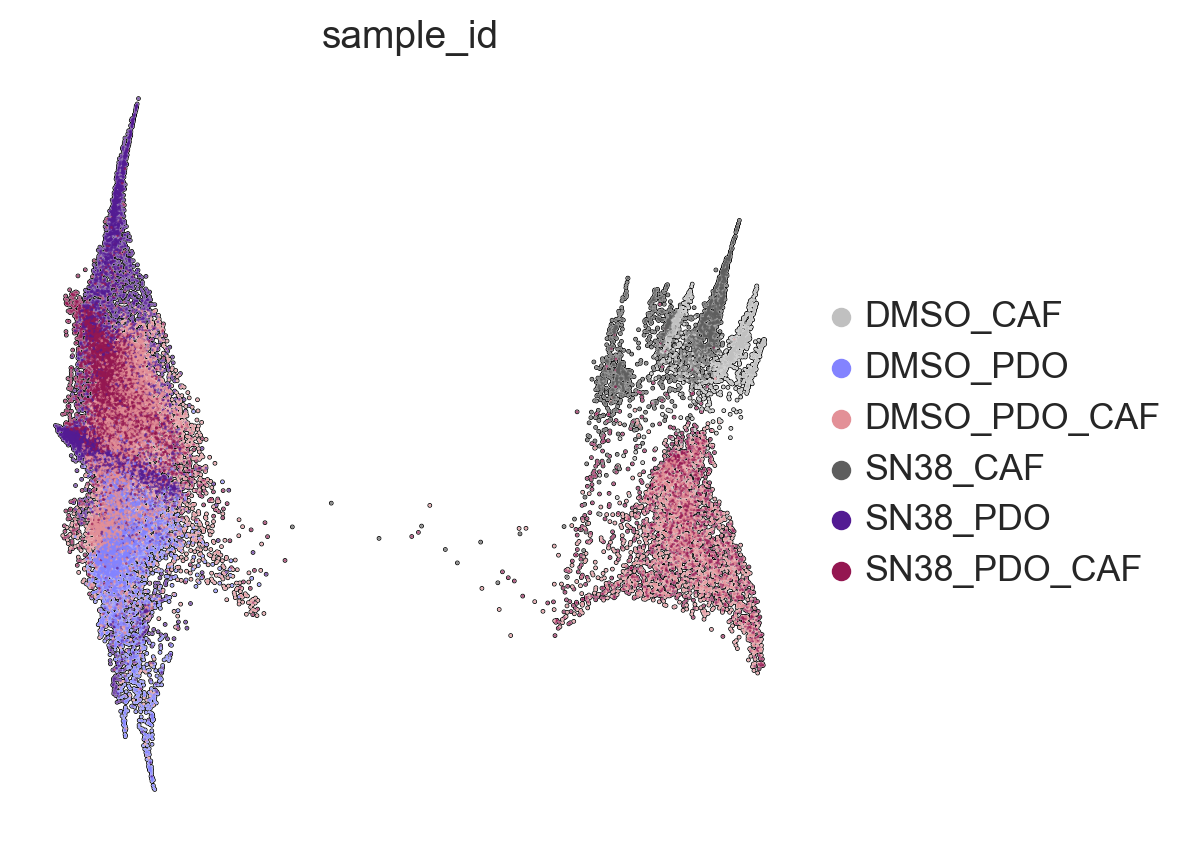

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

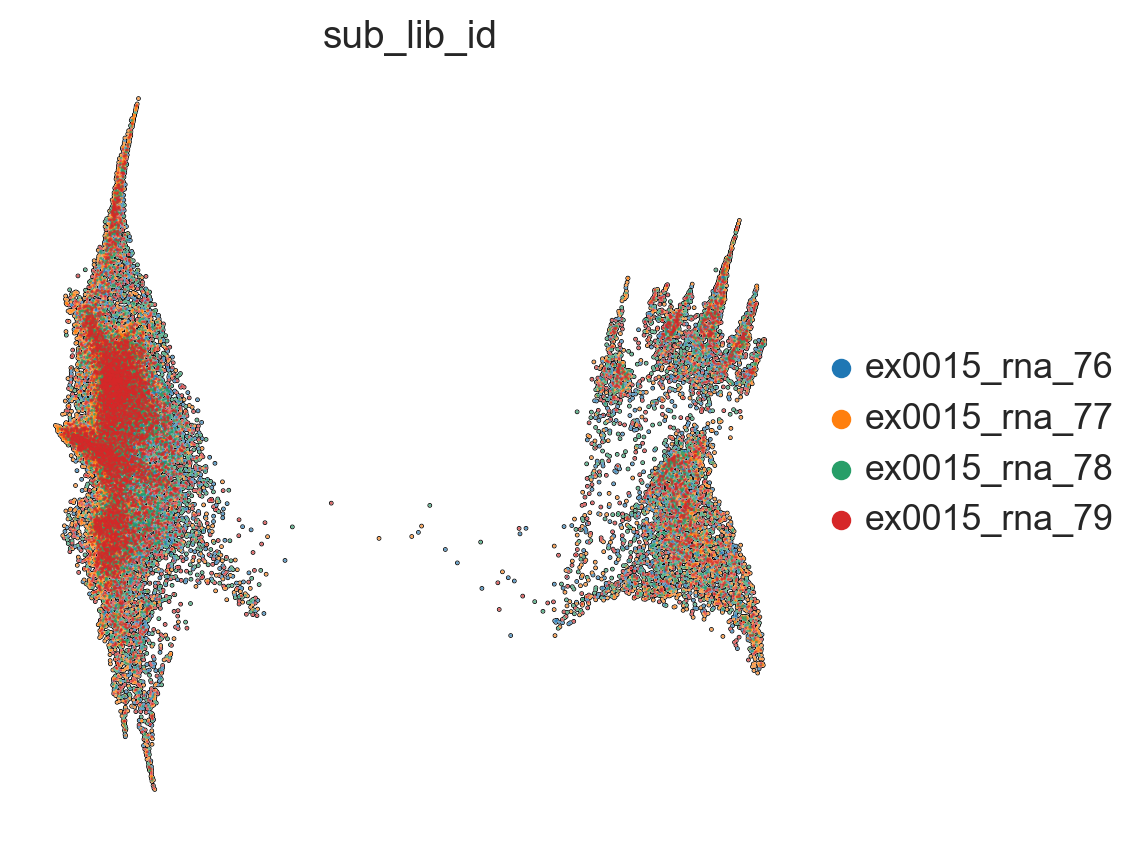

In [43]:
# View the RNA phate
sc.external.pl.phate(signal_data_rna, color=['sample_id'],
frameon=False, add_outline=True, palette=colour_dict_sample, save="_rna_all_conds")

# View the RNA phate
sc.external.pl.phate(signal_data_rna, color=['sub_lib_id'],
frameon=False, add_outline=True, save="_rna_subblibs")

## Cluster Cells to generate Cell type ID

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

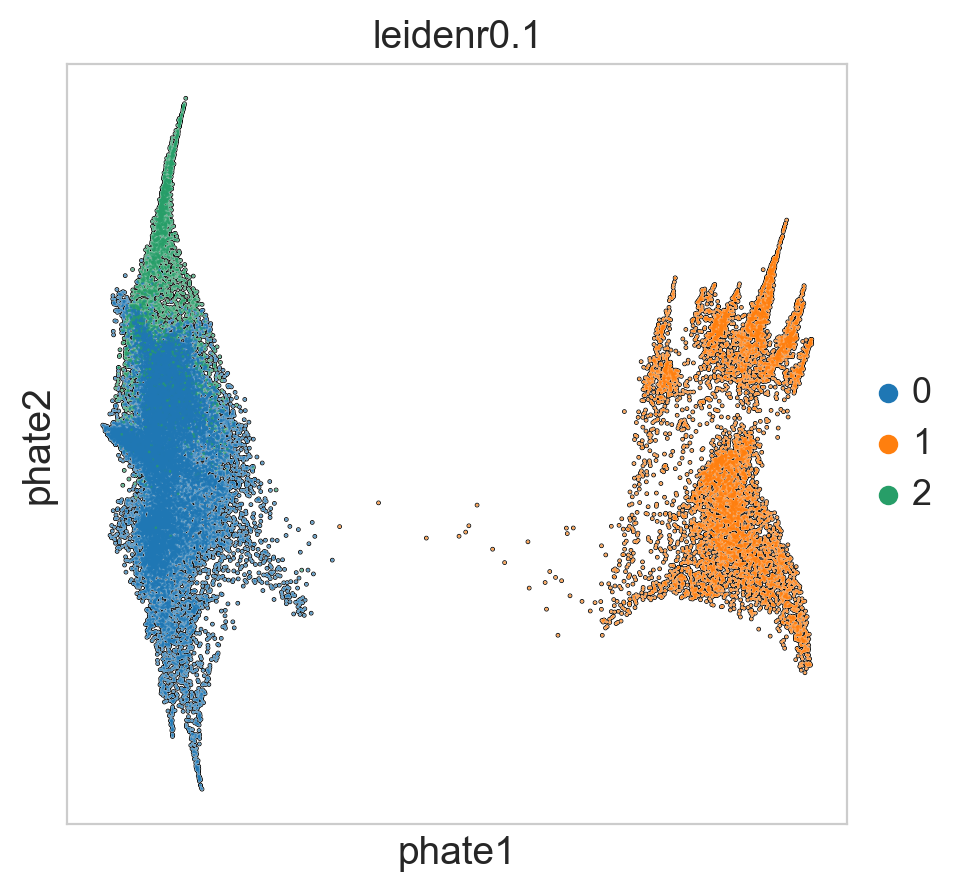

In [44]:
sc.external.pl.phate(signal_data_rna, color='leidenr0.1',
frameon=True, add_outline=True, save="_merged_leiden0.1")

In [45]:
# Get the original cluster labels
original_labels = signal_data_rna.obs['leidenr0.1'].values

new_cluster_names = {
    '0': 'PDO', '1': 'Fibroblast', '2': 'PDO'
    }

# Create an array to store the new cluster labels
new_labels = np.empty_like(original_labels, dtype=object)

# Assign new cluster labels based on the mapping
for original_cluster, new_cluster in new_cluster_names.items():
    mask = original_labels == original_cluster
    new_labels[mask] = new_cluster

# Update the cluster labels in the AnnData object
signal_data_rna.obs['cell_type'] = new_labels

# Merge the two conditions
cell_type_vec = signal_data_rna.obs['cell_type'].astype('str')
condition_vec = signal_data_rna.obs['sample_id'].astype('str')

signal_data_rna.obs['cell_type_condition'] = cell_type_vec + "_" + condition_vec

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

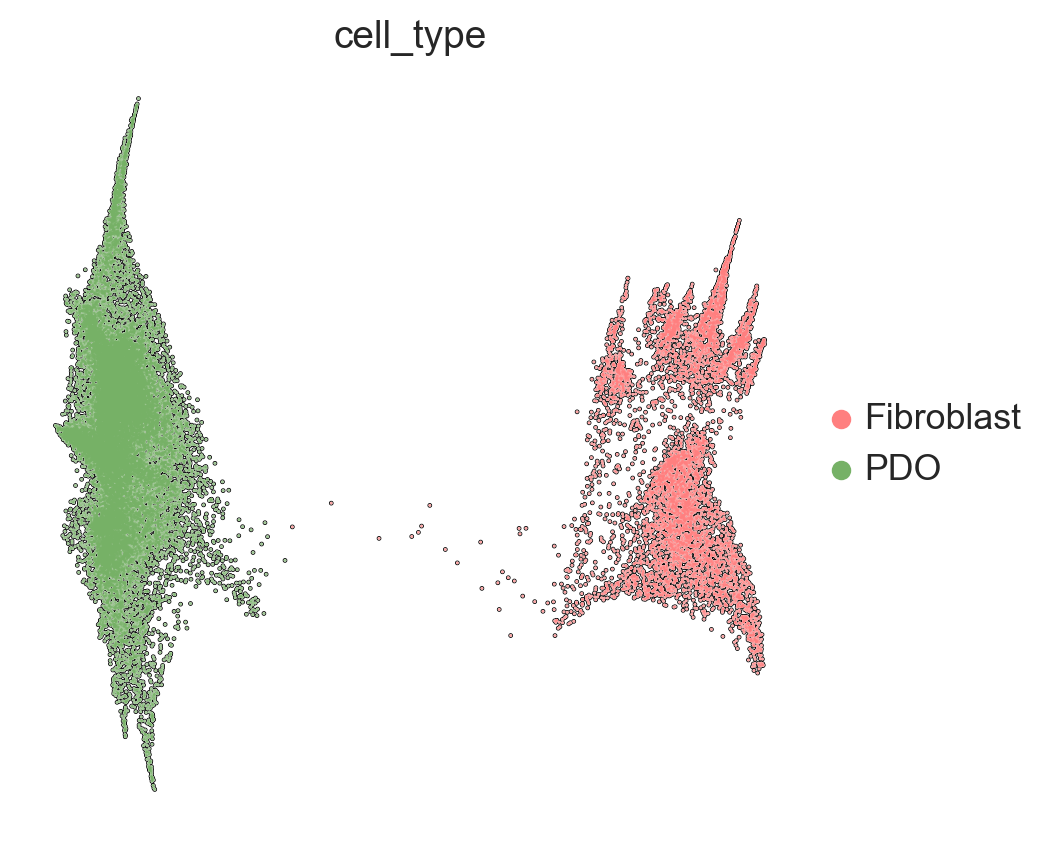

In [46]:
sc.external.pl.phate(signal_data_rna, color='cell_type',
frameon=False, add_outline=True, palette=colour_dict_cell_type, save="_merged_cell_type")

In [47]:
signal_data_rna.obs['cell_type_condition'].value_counts()

cell_type_condition
PDO_DMSO_PDO_CAF           8835
PDO_SN38_PDO_CAF           6667
PDO_SN38_PDO               5045
PDO_DMSO_PDO               3650
Fibroblast_DMSO_PDO_CAF    2347
Fibroblast_SN38_CAF        1719
Fibroblast_SN38_PDO_CAF    1551
Fibroblast_DMSO_CAF        1081
Name: count, dtype: int64

## Normalize ADT modality

In [48]:
# preserve raw counts data for ADT modality
signal_data_adt.layers["counts"] = signal_data_adt.X.copy()

# Package up in Mdata object
mudata_signal_norm = mu.MuData({'rna': signal_data_adt, 'protein': signal_data_adt})

# Implenting the CLR modification
mu.prot.pp.clr(mudata_signal_norm['protein'])

# Extract ADT modality
signal_data_adt = mudata_signal_norm.mod['protein']

signal_data_adt.obsm['rna_phate'] = signal_data_rna.obsm['X_phate']
signal_data_adt.obs['cell_type_condition'] = signal_data_rna.obs['cell_type_condition']
signal_data_adt.obs['cell_type'] = signal_data_rna.obs['cell_type']



/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


## Overview of cell types

In [49]:
cell_type_order = ['PDO', 'Fibroblast']

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed 

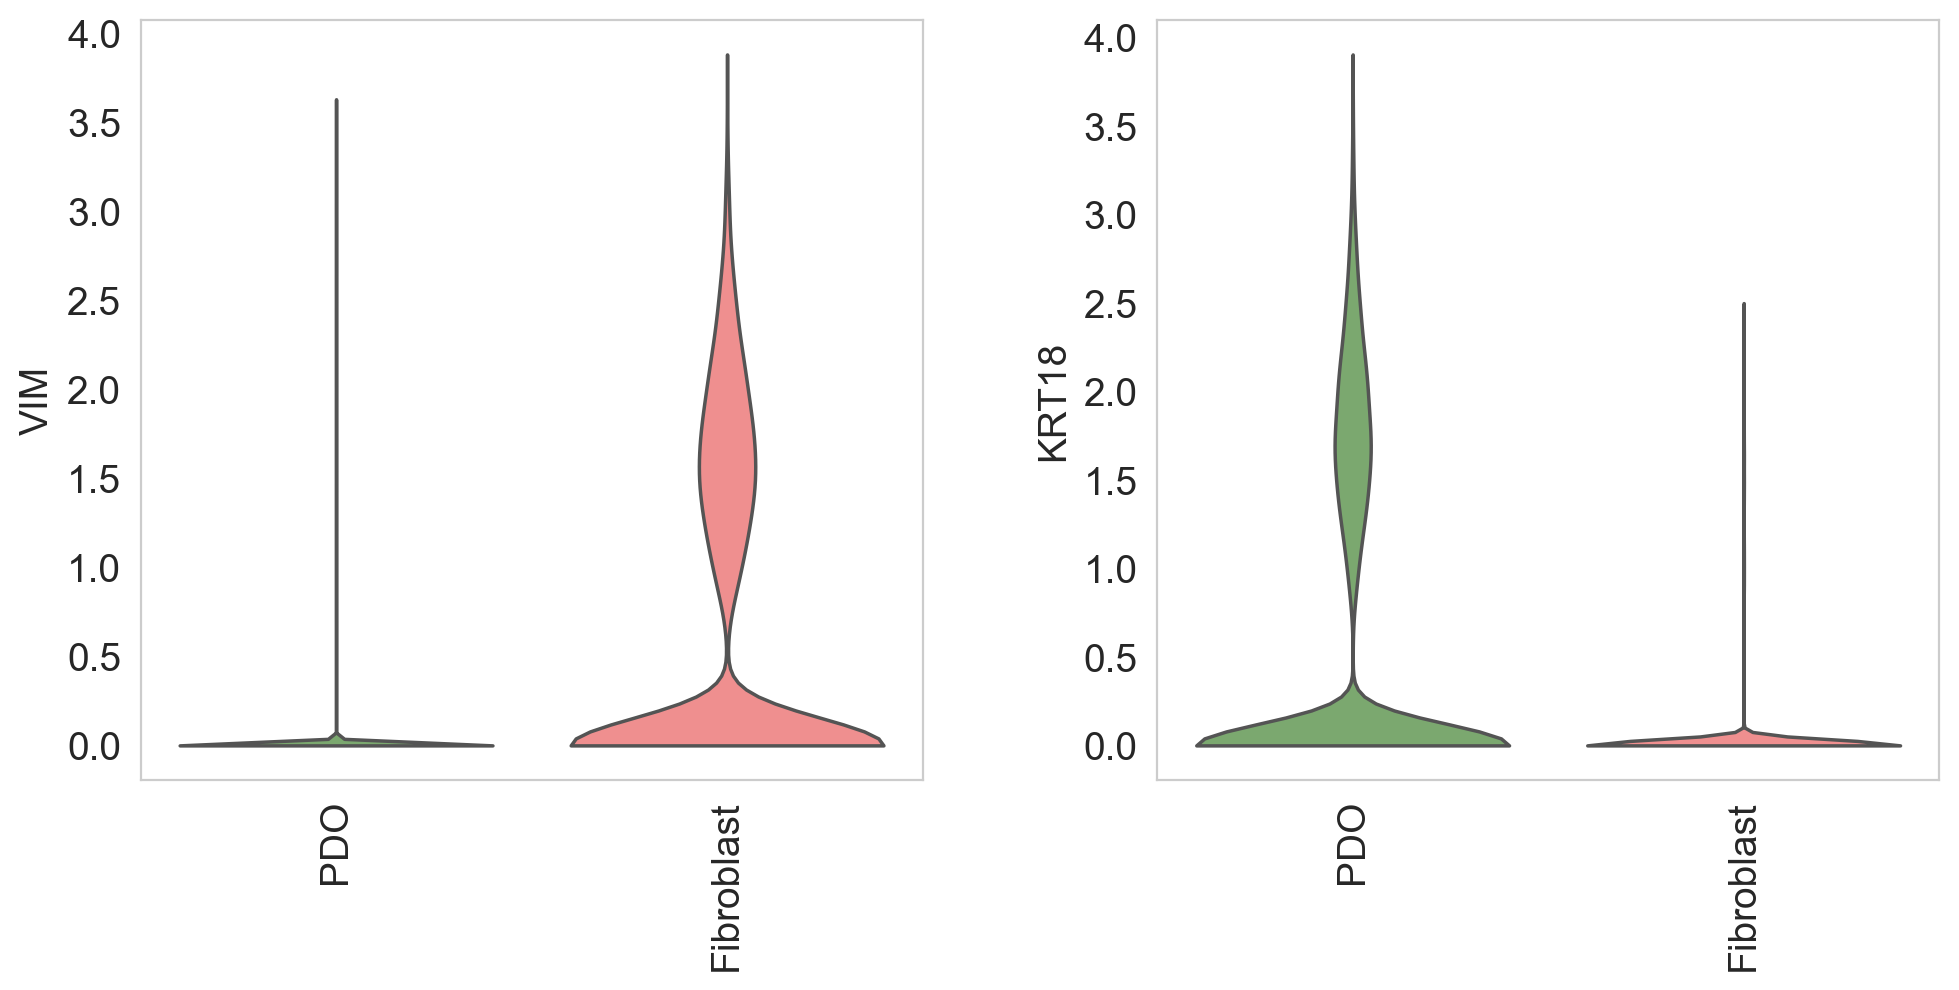

In [50]:
# Cell type RNA markers
sc.pl.violin(signal_data_rna, ['VIM', 'KRT18'], stripplot=False,
            multi_panel=True, groupby='cell_type', palette=colour_dict_cell_type,
            rotation=90, order=cell_type_order, save="_RNA_markers")

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


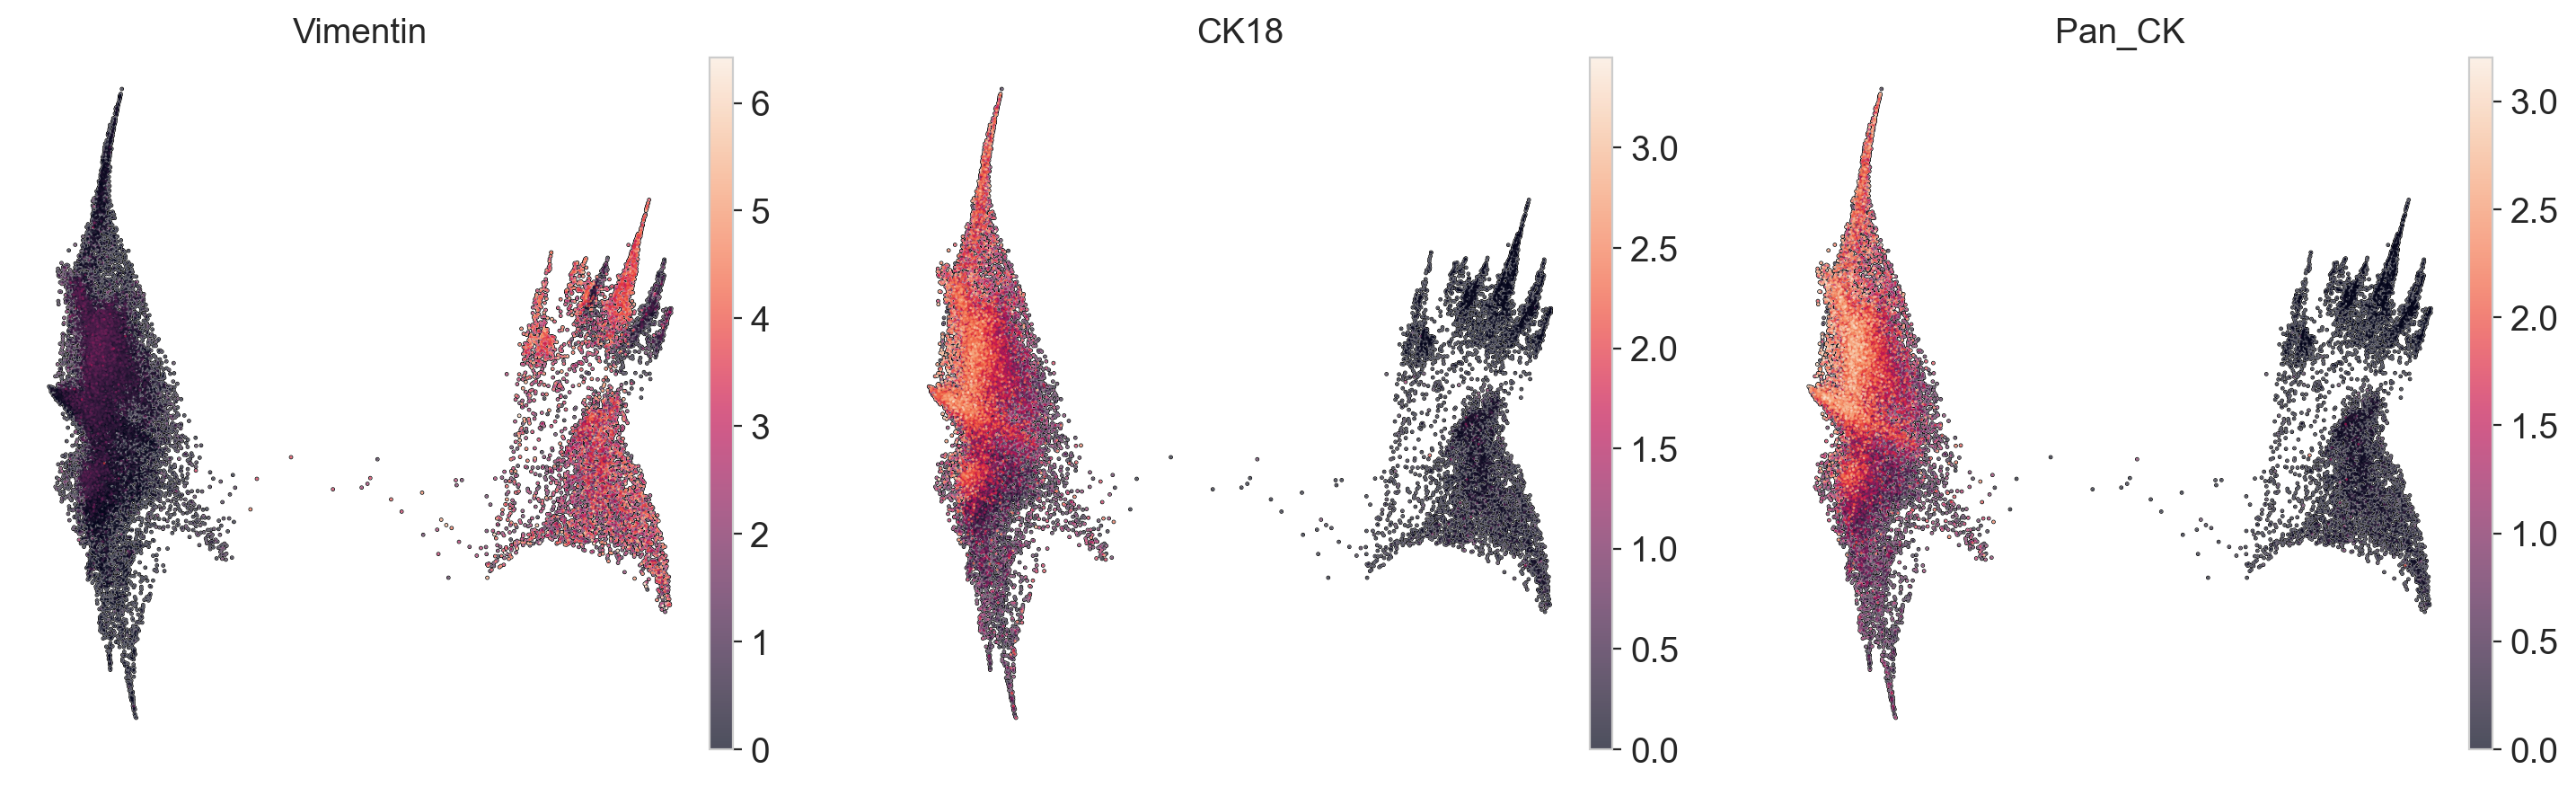

In [51]:
sc.pl.embedding(signal_data_adt, basis='rna_phate', color=[ 'Vimentin', 'CK18', 'Pan_CK'],
frameon=False, add_outline=True, save="_adt_phate_cell_type")


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed 

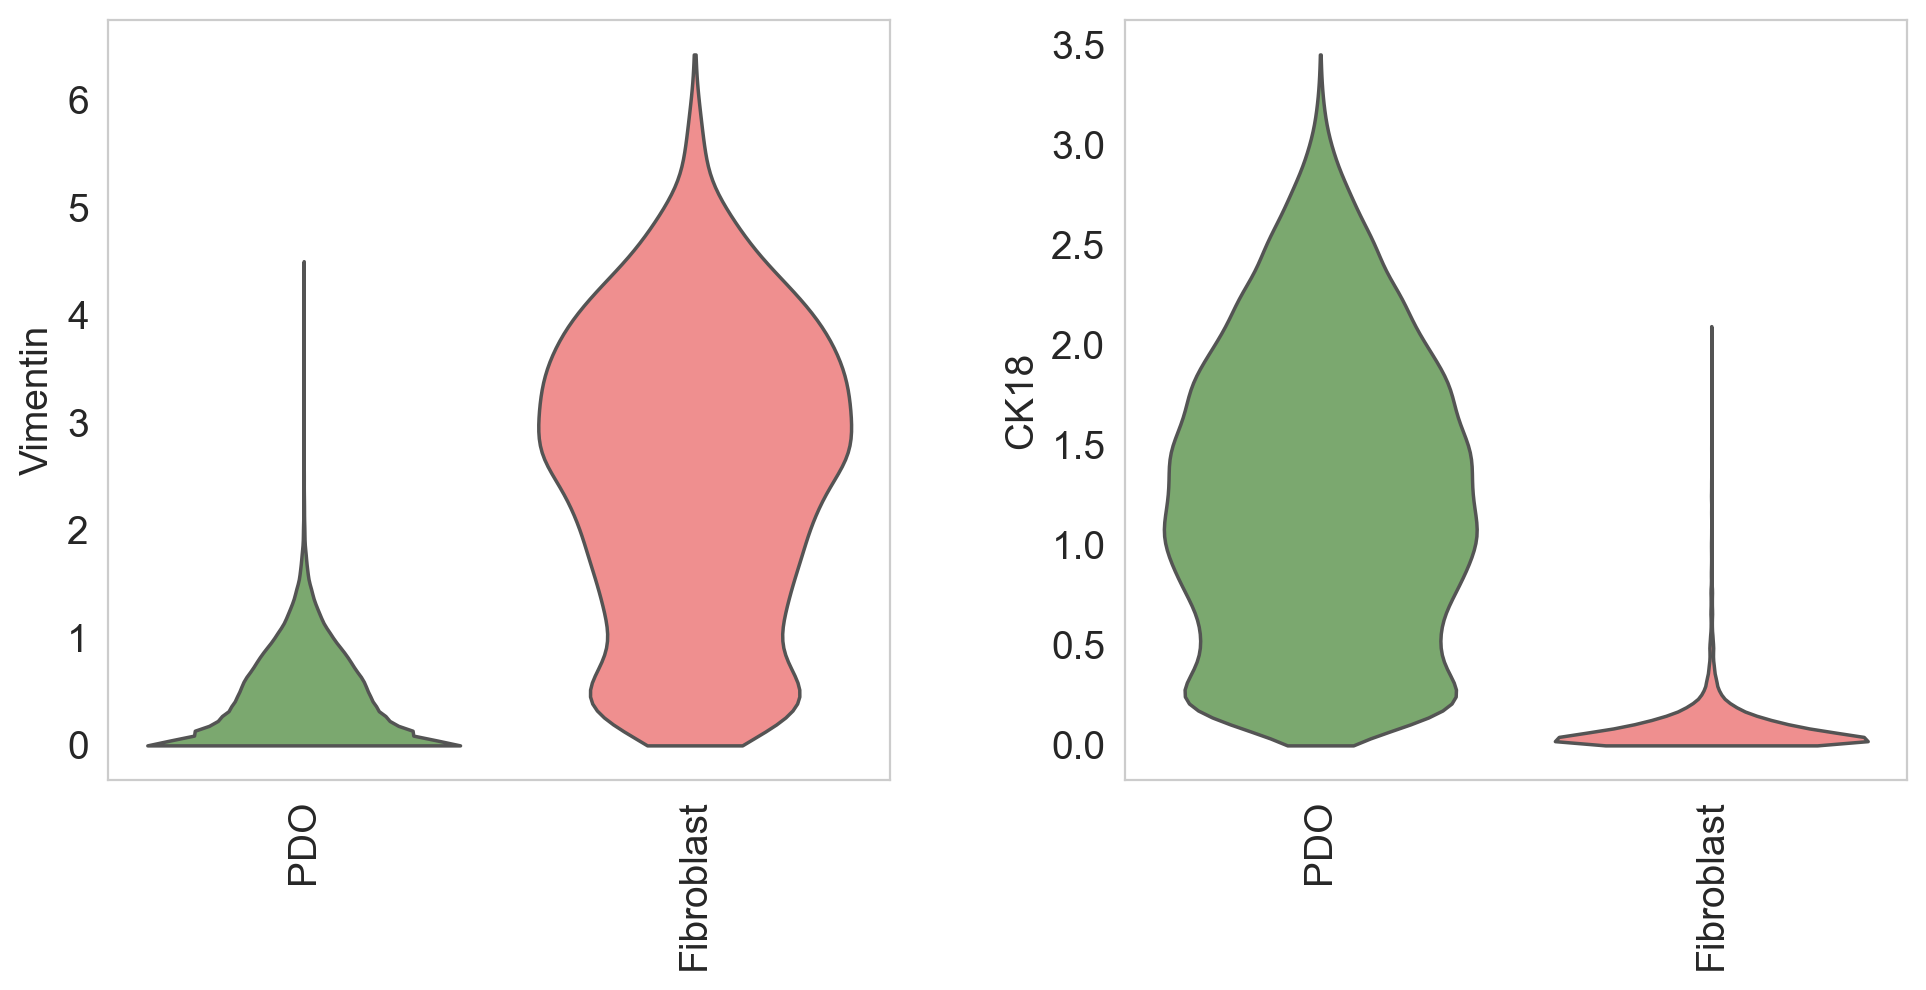

In [52]:
# Cell type ADT markers
sc.pl.violin(signal_data_adt, ['Vimentin', 'CK18'], stripplot=False,
            multi_panel=True, groupby='cell_type', palette=colour_dict_cell_type,
            rotation=90, order=cell_type_order, save="_ADT_markers")

In [53]:
# Load Tirosh cell cycle scoring gene list
cc_gene_df = pd.read_csv('data/human_cc_genes.csv')
s_genes_df = cc_gene_df.loc[cc_gene_df['cycle_status'].str.contains('s_phase'), ['genes', 'cycle_status']]
g2m_genes_df = cc_gene_df.loc[cc_gene_df['cycle_status'].str.contains('g2m_phase'), ['genes', 'cycle_status']]
cell_cycle_genes = [x for x in cc_gene_df['genes'] if x in signal_data_rna.var_names]
sc.tl.score_genes_cell_cycle(signal_data_rna, s_genes=s_genes_df['genes'], g2m_genes=g2m_genes_df['genes'])

calculating cell cycle phase
computing score 'S_score'


    finished: added
    'S_score', score of gene set (adata.obs).
    514 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


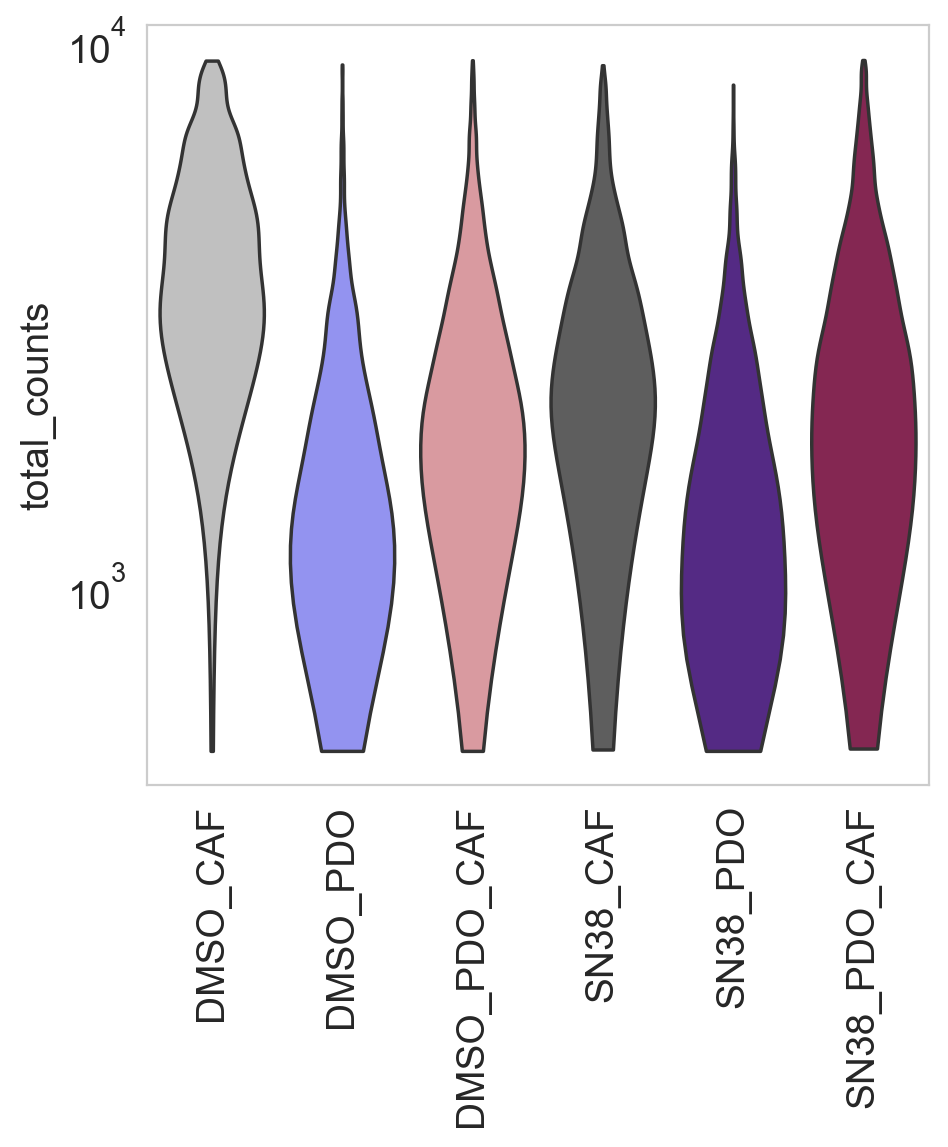

In [54]:
# Post filtering total counts ADT data
sc.pl.violin(signal_data_rna, 'total_counts', stripplot=False, log=True,
            multi_panel=True, groupby='sample_id', palette=colour_dict_sample,
            rotation=90, save='_rna_total_counts')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


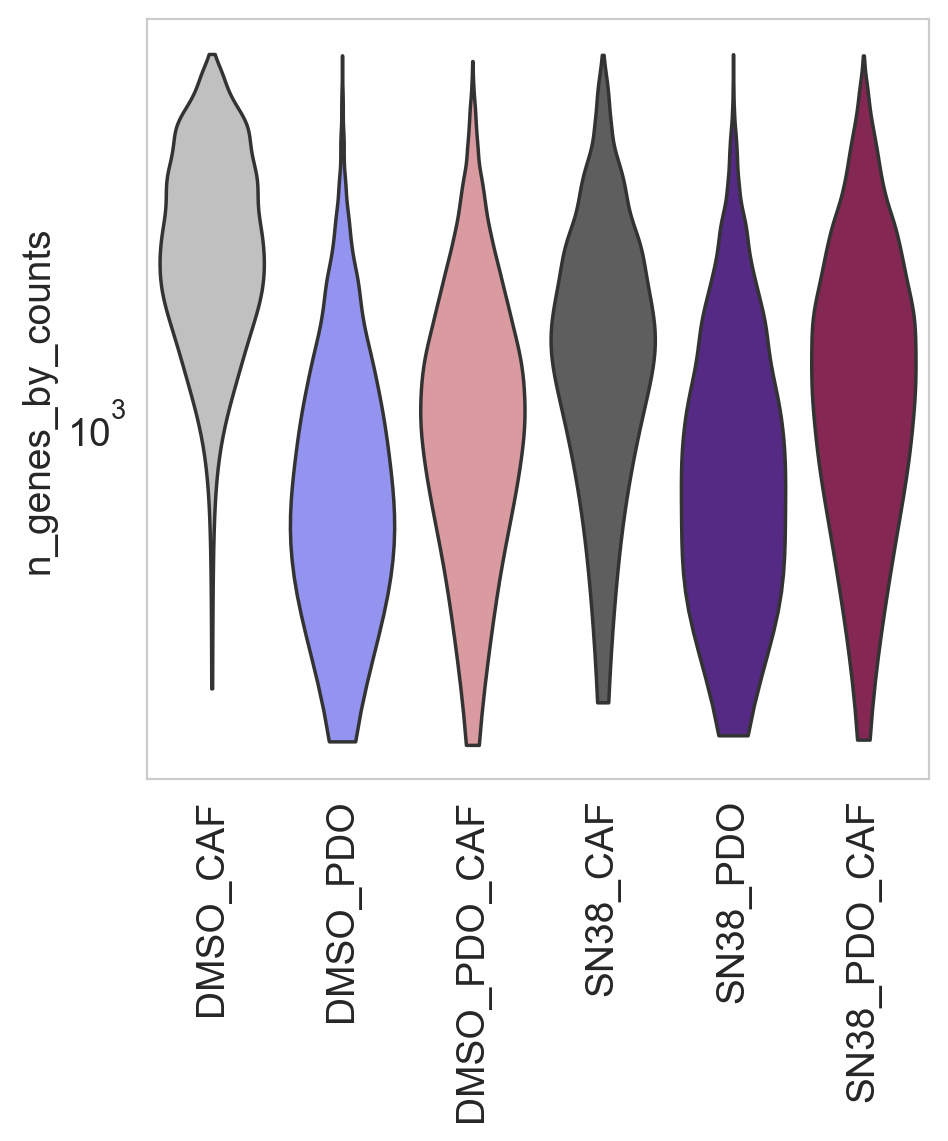

In [55]:
# Post filtering total counts ADT data
sc.pl.violin(signal_data_rna, 'n_genes_by_counts', stripplot=False, log=True,
            multi_panel=True, groupby='sample_id', palette=colour_dict_sample,
            rotation=90, save='_rna_ngenes')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


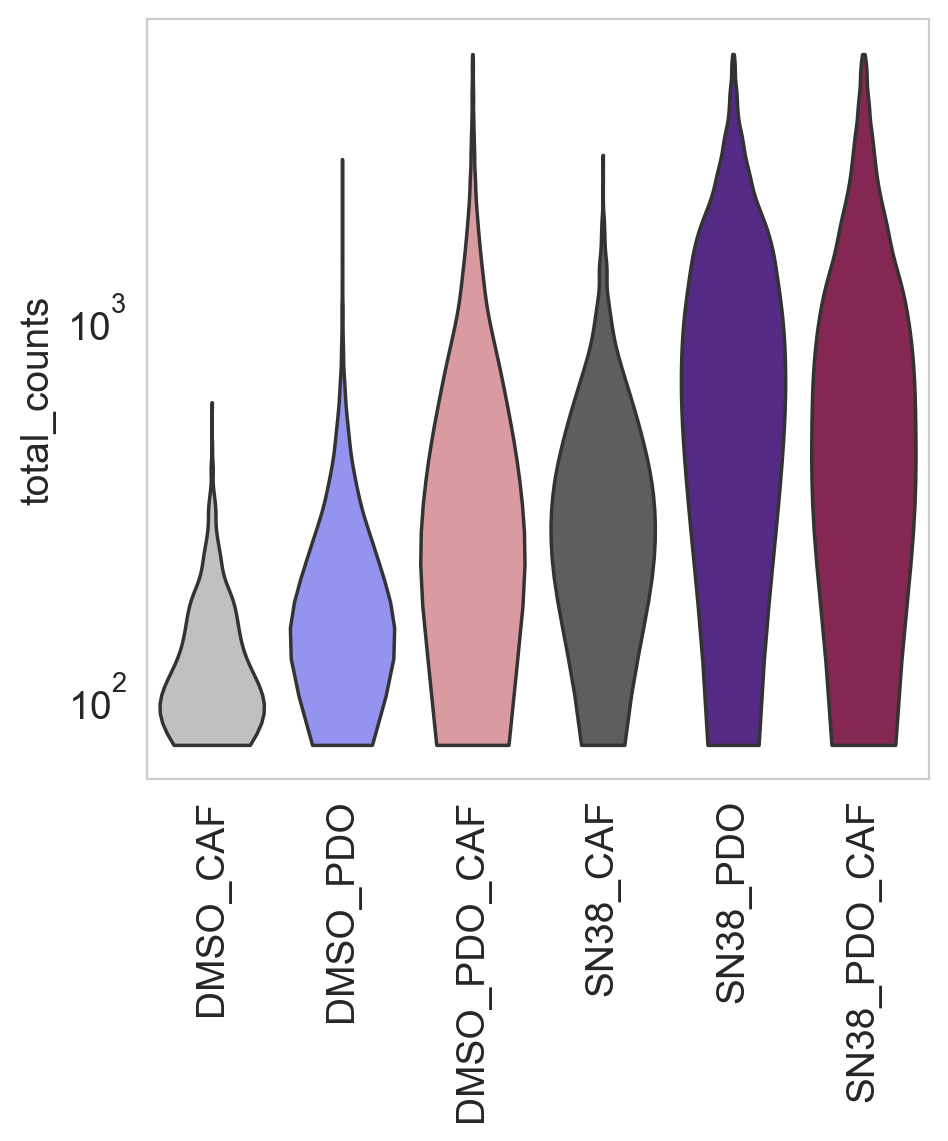

In [56]:
# Post filtering total counts ADT data
sc.pl.violin(signal_data_adt, 'total_counts', stripplot=False, log=True,
            multi_panel=True, groupby='sample_id', palette=colour_dict_sample,
            rotation=90, save='_adt_total_counts')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


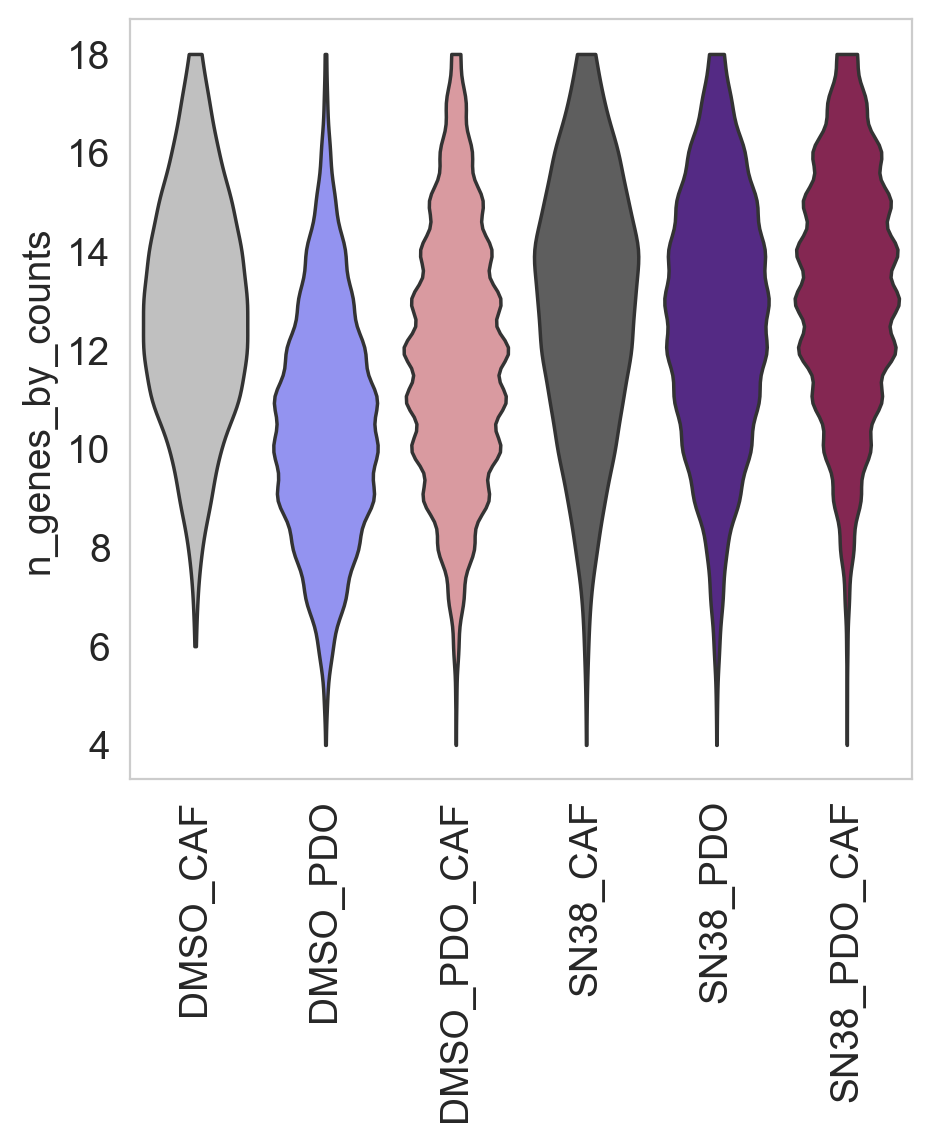

In [57]:
# Post filtering total counts ADT data
sc.pl.violin(signal_data_adt, 'n_genes_by_counts', stripplot=False, log=False,
            multi_panel=True, groupby='sample_id', palette=colour_dict_sample,
            rotation=90, save='_adt_ngenes')

## Export AnnData object for downstream analysis

In [58]:
# Load/write stopping point
signal_data_rna_export  = signal_data_rna.copy()
signal_data_adt_export = signal_data_adt.copy()

# Write individually
signal_data_rna_export.write_h5ad('ex0015_pdo_rna_adata.h5ad')
signal_data_adt_export.write_h5ad('ex0015_adt_adt_adata.h5ad')